<a href="https://colab.research.google.com/github/pengppng/finalprj/blob/breastCNN/Classify_BreastUltrasound_NN_(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aryashah2k_breast_ultrasound_images_dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Data source import complete.


# 📌Importing all needed Librarires

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

tf.random.set_seed(42)
np.random.seed(42)

<h6>🔴Data about Breast Ultrasound Images Dataset
<h6> 🔴and contains 3 files (Classes) [benign,malignant,normal]


# 📌 Display 2 images from each class

In [13]:
folder_name = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
class_names = ['benign', 'malignant', 'normal']   # ต้องตรงกับชื่อโฟลเดอร์

IMG_SIZE = 300
NUM_CLASSES = len(class_names)
BATCH_SIZE = 32

In [14]:
# for file in files_names:
#     path = os.path.join(folder_name, file)
#     x = 0
#     fig, axes = plt.subplots(1,2, figsize=(25, 10))
#     for img in os.listdir(path):
#         img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#         axes[x].imshow(img_array, cmap='gray')
#         axes[x].set_title(f"img {x+1} from {file} category")
#         x += 1
#         if x == 2:
#             break

#     plt.suptitle(file, fontsize=26)
#     plt.tight_layout()
#     plt.show()


<h6> 🔴we notice that images with different sizes

# 📌choose the best size for the images (old)

In [15]:
img_sz = [50, 100, 200, 300, 400, 500]
plt.figure(figsize=(20, 5))

for i, sz in enumerate(img_sz):
    new_array = cv2.resize(img_array, (sz, sz))
    plt.subplot(1, len(img_sz), i+1)
    plt.imshow(new_array, cmap='gray')
    plt.title(f"img with size {sz} * {sz}")

plt.show()


NameError: name 'img_array' is not defined

<Figure size 2000x500 with 0 Axes>

In [ ]:
#size (300*300) is okay
img_sz=300

# 📌Preprocessing: Grayscale + CLAHE + Resize + 3-channel

In [16]:
# 📌 ฟังก์ชันเพิ่ม contrast ด้วย CLAHE แล้วแปลงเป็น 3-channel
def preprocess_image(path, img_size=IMG_SIZE):
    # อ่านภาพเป็น grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # CLAHE (เพิ่ม contrast สำหรับ ultrasound)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Resize
    img = cv2.resize(img, (img_size, img_size))

    # แปลง grayscale -> 3-channel (จำเป็นสำหรับ EfficientNet)
    img_3ch = np.stack([img, img, img], axis=-1)  # (H, W) -> (H, W, 3)

    return img_3ch

# 📌Load all data n make  (x, y)

In [17]:
# 📌 โหลดภาพทั้งหมดใส่ใน list แล้วค่อยแปลงเป็น array

X = []
y_int = []  # label แบบตัวเลข 0,1,2

for idx, cls in enumerate(class_names):
    path = os.path.join(folder_name, cls)
    print(f"Loading class: {cls} ({idx}) from {path}")

    for img_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img_name)

        # ข้ามไฟล์ mask หรือ GT (บาง dataset มีไฟล์ *_mask.png)
        if 'mask' in img_name.lower():
            continue

        img = preprocess_image(img_path)
        if img is None:
            continue

        X.append(img)
        y_int.append(idx)

X = np.array(X, dtype='float32')   # shape: (N, H, W, 3)
y_int = np.array(y_int)            # shape: (N,)

print("X shape:", X.shape)
print("y shape:", y_int.shape)
print("Class distribution:", np.bincount(y_int))

Loading class: benign (0) from /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign


100%|██████████| 891/891 [00:09<00:00, 94.81it/s]


Loading class: malignant (1) from /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant


100%|██████████| 421/421 [00:04<00:00, 93.01it/s] 


Loading class: normal (2) from /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal


100%|██████████| 266/266 [00:03<00:00, 88.44it/s]


X shape: (780, 300, 300, 3)
y shape: (780,)
Class distribution: [437 210 133]


# 📌Train / Validation / Test Split (แยกจริงจัง) ด้วย stratify

In [18]:
# แบ่ง Train (70%) + Temp (30%)
X_train, X_temp, y_train_int, y_temp_int = train_test_split(
    X, y_int,
    test_size=0.3,
    random_state=42,
    stratify=y_int
)

# แบ่ง Temp -> Val (15%) + Test (15%) จากทั้งหมด
X_val, X_test, y_val_int, y_test_int = train_test_split(
    X_temp, y_temp_int,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_int
)

print("Train:", X_train.shape, y_train_int.shape)
print("Val:  ", X_val.shape, y_val_int.shape)
print("Test: ", X_test.shape, y_test_int.shape)


Train: (546, 300, 300, 3) (546,)
Val:   (117, 300, 300, 3) (117,)
Test:  (117, 300, 300, 3) (117,)


# 📌One-hot labels (สำหรับ training + AUC Metric)

In [19]:
# 📌 แปลง label เป็น one-hot สำหรับ loss='categorical_crossentropy'
y_train = keras.utils.to_categorical(y_train_int, NUM_CLASSES)
y_val   = keras.utils.to_categorical(y_val_int, NUM_CLASSES)
y_test  = keras.utils.to_categorical(y_test_int, NUM_CLASSES)

print("y_train one-hot shape:", y_train.shape)


y_train one-hot shape: (546, 3)


# 📌 คำนวณ class weight แบบ balanced (แก้ปัญหา class imbalance)

In [20]:
# Class Weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=y_train_int
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.5947712418300654), 1: np.float64(1.2380952380952381), 2: np.float64(1.956989247311828)}


# 📌 Data augmentation (random flip / rotation / zoom / shift) by Keras layers

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ],
    name="data_augmentation"
)

# 📌 สร้าง EfficientNetB0 base + head
🔹 Cell 9 – สร้าง EfficientNetB0 (Transfer Learning)

In [22]:
def build_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # Augmentation
    x = data_augmentation(inputs)

    # Preprocess ให้เข้ากับ EfficientNet (scale -> [-1, 1])
    # x = layers.Lambda(preprocess_input, name="effnet_preprocess")(x) can't load model
    x = preprocess_input(x)

    # Base model (ไม่เอา top, โหลด weight pre-trained ImageNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling="avg"
    )

    # Freeze base model ช่วงแรก (ถ้าอยาก fine-tune ค่อย unfreeze ทีหลัง)
    base_model.trainable = False

    x = base_model.output
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_BreastUS")
    return model

model = build_efficientnet_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EfficientNetB0_BreastUS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 📌 Compile โมเดล
🔹 Cell 10 – Compile + Callbacks (EarlyStopping + ModelCheckpoint + ReduceLROnPlateau)

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy"
        # (Recall, AUC จะไปคำนวณทีหลังละเอียด ๆ ด้วย sklearn)
    ]
)

# 📌 Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_efficientnet_breastus.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

# 📌 Training
🔹 Cell 11 – Train EfficientNet (ใช้ class_weights + validation set)

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4170 - loss: 1.1296
Epoch 1: val_loss improved from inf to 0.80187, saving model to best_efficientnet_breastus.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.4200 - loss: 1.1255 - val_accuracy: 0.6581 - val_loss: 0.8019 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6544 - loss: 0.8194
Epoch 2: val_loss improved from 0.80187 to 0.79433, saving model to best_efficientnet_breastus.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.6521 - loss: 0.8204 - val_accuracy: 0.6325 - val_loss: 0.7943 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6829 - loss: 0.6950
Epoch 3: val_loss improved from 0.79433 to 0.79030, saving model to best_efficientnet_breastus.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.6812 - loss: 0.6983 - val_accuracy: 0.6581 - val_loss: 0.7903 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━

# 📌 Plot Accuracy & Loss
🔹 Cell 12 – Plot Learning Curves (optional แต่ดีมาก)

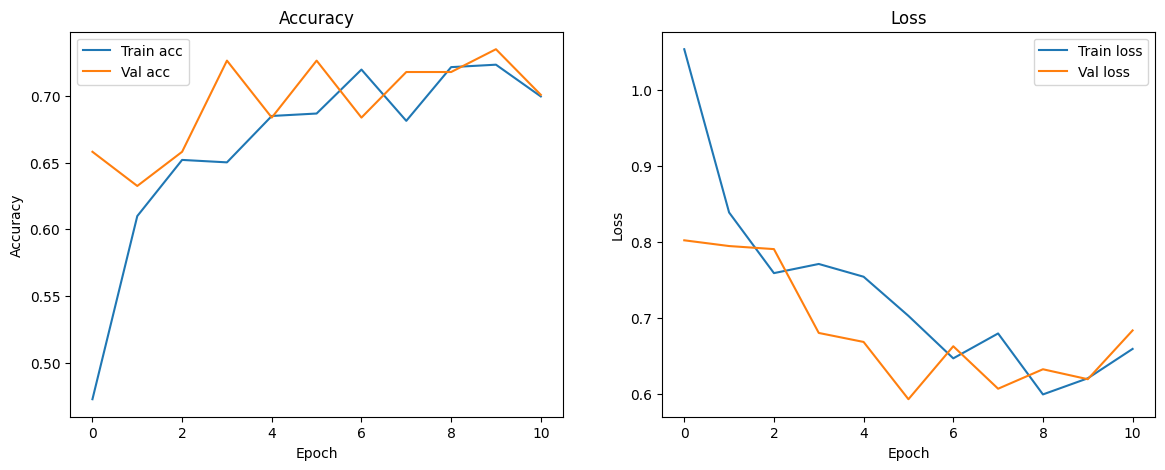

In [28]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#🔹 Cell 13 – Load best model (เผื่อถูก Save จาก checkpoint)

In [29]:
# 📌 โหลด best model จากไฟล์
best_model = keras.models.load_model("best_efficientnet_breastus.keras")

#🔹 Cell 14 – Evaluation (Accuracy + F1 + Recall + AUC)

In [30]:
# 📌 Predict บน Test set
y_pred_proba = best_model.predict(X_test)
y_pred_int = np.argmax(y_pred_proba, axis=1)

# Accuracy
test_acc = np.mean(y_pred_int == y_test_int)
print(f"Test Accuracy: {test_acc:.4f}")

# F1-score
macro_f1 = f1_score(y_test_int, y_pred_int, average="macro")
print(f"Macro F1-score: {macro_f1:.4f}")

# Recall (macro)
from sklearn.metrics import recall_score
macro_recall = recall_score(y_test_int, y_pred_int, average="macro")
print(f"Macro Recall: {macro_recall:.4f}")

# AUC (multi-class One-vs-Rest)
auc_macro_ovr = roc_auc_score(
    y_test,              # one-hot
    y_pred_proba,
    multi_class="ovr",
    average="macro"
)
print(f"Macro AUC (OvR): {auc_macro_ovr:.4f}")

# รายงานละเอียดรายคลาส
print("\nClassification report:")
print(classification_report(y_test_int, y_pred_int, target_names=class_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step
Test Accuracy: 0.5897
Macro F1-score: 0.5771
Macro Recall: 0.6370
Macro AUC (OvR): 0.8174

Classification report:
              precision    recall  f1-score   support

      benign       0.81      0.53      0.64        66
   malignant       0.50      0.58      0.54        31
      normal       0.42      0.80      0.55        20

    accuracy                           0.59       117
   macro avg       0.58      0.64      0.58       117
weighted avg       0.66      0.59      0.60       117



# 📌 Confusion Matrix + Heatma


Confusion Matrix:
 [[35 16 15]
 [ 6 18  7]
 [ 2  2 16]]


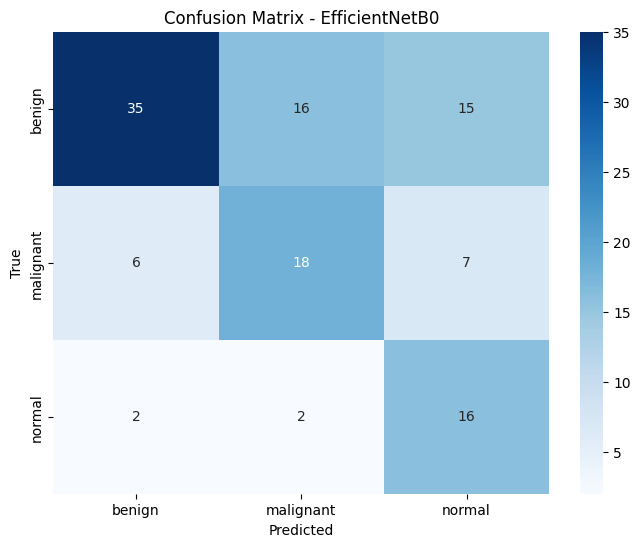

In [31]:
cm = confusion_matrix(y_test_int, y_pred_int)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()